# Machine Learning - Assignment 5

This week we look at regularization of linear regressions. Splitting data into training, validation and testing sets and using their errors to test for bias or variance problems

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.optimize as op
from scipy.io import loadmat

## Problem 1: Regularized Linear Regression

### Problem 1.1: Visualizing the Data

In [113]:
data = loadmat('./data/ex5data1.mat')
X, y = data["X"], data["y"].ravel()
Xval, yval = data["Xval"], data["yval"].ravel()
Xtest, ytest = data["Xtest"], data["ytest"].ravel()
print(X.shape, y.shape)
print(Xval.shape, yval.shape)
print(Xtest.shape, ytest.shape)

(12, 1) (12,)
(21, 1) (21,)
(21, 1) (21,)


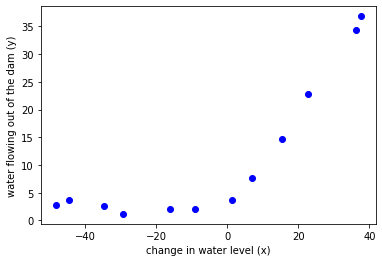

In [114]:
plt.figure()
plt.scatter(x=X, y=y, color="blue")
plt.ylabel("water flowing out of the dam (y)")
plt.xlabel("change in water level (x)")
plt.show()

### Problem 1.2: Regularized linear regression cost function

We recall the cost function for regularized linear regression -->$$𝐽(ø)={1\over{2𝑚}}∑(ℎ_ø(𝑥^{(i)})−𝑦^{(𝑖)})^2 +\frac{\lambda}{2m}\sum_{j=1}^n{\theta_j^2}$$

In [249]:
def linearRegCostFunction(theta, X, y, lam):
    h = np.dot(X,theta)
    t = np.zeros(len(theta))
    t[1:] = theta[1:]
    J = np.dot((np.dot(X,theta)-y),(np.dot(X,theta)-y))/(2*len(X))
    grad = (np.dot(X.T,(h-y))/len(X))+((t*lam)/len(X))
    return J, grad
    
def cost(theta, X, y, lam):
    h = np.dot(X,theta)
    t = np.zeros(len(theta))
    t[1:] = theta[1:]
    J = np.dot((h-y),(h-y))/(2*len(X)) + lam * np.dot(t, t) / (2 * X.shape[0])
    return J

def gradient(theta, X, y,lam):
    h = np.dot(X,theta)
    t = np.zeros(len(theta))
    t[1:] = theta[1:]
    grad = (np.dot(X.T,(h-y))/len(X))+((t*lam)/len(X))
    return grad    

In [250]:
theta = [1, 1]
lam = 1
X_train = np.column_stack((np.ones(len(X)),X))
J, grad = linearRegCostFunction(theta, X_train, y, lam)
print('Cost at theta = (1,1) is: ',J)

Cost at theta = (1,1) is:  303.9515255535976


### Problem 1.3: Regularized linear regression gradient

In [251]:
print('Gradient at theta = (1,1) is: ',grad)

Gradient at theta = (1,1) is:  [-15.30301567 598.25074417]


### Problem 1.4: Fitting linear regression

Now we compute the optimal values of $$\theta$$

In [252]:
def trainLinearReg(X, y, lam):
    initial_theta = np.zeros(X.shape[1])
    res = op.minimize(fun=cost, x0=initial_theta, args=(X, y,lam),
                        method='CG', jac = gradient)
    return res.x

In [253]:
lam = 0
X_train = np.column_stack((np.ones(len(X)),X))
theta_opt = trainLinearReg(X_train, y, lam)
print(theta_opt)

[13.08790351  0.36777923]


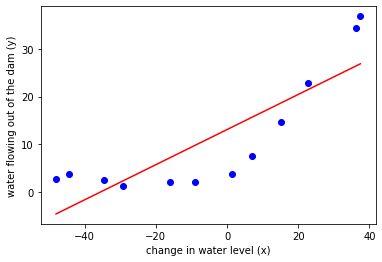

In [254]:
X_dummy=np.linspace(min(X),max(X),len(X))
X_dummy_train = np.column_stack((np.ones(len(X_dummy)),X_dummy))
h = np.dot(X_dummy_train,theta_opt)
plt.figure()
plt.scatter(x=X, y=y, color="blue")
plt.plot(X_dummy,h, color="red")
plt.ylabel("water flowing out of the dam (y)")
plt.xlabel("change in water level (x)")
plt.show()

## Problem 2: Bias-variance

We are going to plot training and test errors on a learning curve to diagnose bias-variance problems.

### Problem 2.1: Learning Curves

In [255]:
def learningCurve(X, y, Xval, yval, lam):
    error_train = []
    error_val = []
    for i in range(X.shape[0]):
        theta = trainLinearReg(X[:i + 1], y[:i + 1], lam)
        h_train = np.dot(X[:i + 1], theta)
        error_train.append(np.dot(h_train - y[:i + 1], h_train - y[:i + 1]) / (2 * (i + 1)))
        h_val = np.dot(Xval, theta)
        error_val.append(np.dot(h_val - yval, h_val - yval) / (2 * Xval.shape[0]))
    return error_train, error_val

In [256]:
X_train = np.column_stack((np.ones(len(X)),X))
X_val = np.column_stack((np.ones(len(Xval)),Xval))
lam = 0
error_train, error_val = learningCurve(X_train, y, X_val, yval, lam)

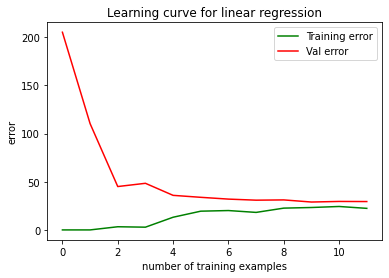

In [257]:
plt.figure()
plt.plot(range(len(X)),error_train,color ="green", label = "Training error")
plt.plot(range(len(X)),error_val, color = "red", label = "Val error")
plt.ylabel("error")
plt.xlabel("number of training examples")
plt.title("Learning curve for linear regression")
plt.legend()
plt.show()

We can see from this graph that there is a high bias problem (underfitting), now we can try to fix it by adding more features (polynomial terms)

## Problem 3: Polynomial Regression

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, we will address this problem by adding more features (polynomials)

In [258]:
def polyFeatures(X, p):
    X_poly = np.power(X, range(1,p+1))
    return X_poly

### Problem 3.1: Learning Polynomial Reg

In [259]:
def featureNormalize(X):
    mean = np.mean(X, axis = 0)
    std = np.std(X, axis = 0, ddof = 1)
    X_norm = (X-mean)/std
    return X_norm, mean, std

In [260]:
p = 8

We first map X into polynomial features and normalize them

In [261]:
X_poly = polyFeatures(X, p)
X_poly_norm, mean, std = featureNormalize(X_poly)
X_poly_train_final = np.column_stack((np.ones(len(X_poly)),X_poly_norm))

Then we do the same with X_val and X_test but normalizing using mean and std from X_train

In [262]:
X_poly_test = polyFeatures(Xtest, p)
X_poly_test_norm = (X_poly_test-mean)/std
X_poly_test_final = np.column_stack((np.ones(len(X_poly_test_norm)),X_poly_test_norm))

In [263]:
X_poly_val = polyFeatures(Xval, p)
X_poly_val_norm = (X_poly_val-mean)/std
X_poly_val_final = np.column_stack((np.ones(len(X_poly_val_norm)),X_poly_val_norm))

In [264]:
print('Normalized Training Example 1:\n')
print(X_poly_train_final[0])

Normalized Training Example 1:

[ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]


In [265]:
lam = 0
theta_opt = trainLinearReg(X_poly_train_final, y, lam)

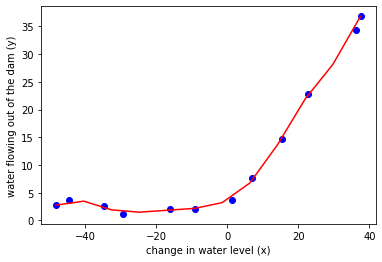

In [266]:
X_dummy = np.linspace(min(X),max(X),len(X))
X_dummy_poly = polyFeatures(X_dummy, p)
X_dummy_norm = (X_dummy_poly-mean)/std
X_dummy_train = np.column_stack((np.ones(len(X_dummy_norm)),X_dummy_norm))
h = np.dot(X_dummy_train,theta_opt)
plt.figure()
plt.scatter(x=X, y=y, color="blue")
plt.plot(X_dummy,h, color="red")
plt.ylabel("water flowing out of the dam (y)")
plt.xlabel("change in water level (x)")
plt.show()

Now, we see there is a perfect fit for the training data. Maybe by adding more polynomial features we created an overfitting (high variance) problem

In [267]:
lam = 0
error_train, error_val = learningCurve(X_poly_train_final, y, X_poly_val_final, yval, lam)

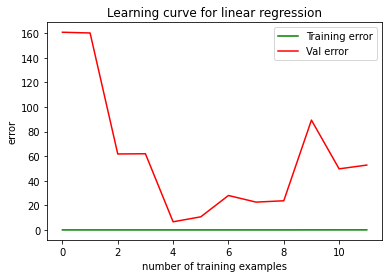

In [268]:
plt.figure()
plt.plot(range(len(X)),error_train,color ="green", label = "Training error")
plt.plot(range(len(X)),error_val, color = "red", label = "Val error")
plt.ylabel("error")
plt.xlabel("number of training examples")
plt.title("Learning curve for linear regression")
plt.legend()
plt.show()

After plotting the errors of the training vs CV sets, we can clearly see we created a high variance and overfitting problem with out training set. A way to fix this is to adjust the regularization parameter $$\lambda$$

### Problem 3.3: Selecting lambda using a cross validation set

The following function will try lambda in the following range: {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10}. This will hep us adjust for overfitting caused by adding too many polynomial features

In [269]:
def validationCurve(X, y, Xval, yval):
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    error_train = []
    error_val = []
    for i in range(len(lambda_vec)):
        theta = trainLinearReg(X, y, lambda_vec[i])
        h_train = np.dot(X, theta)
        error_train.append(np.dot(h_train-y,h_train-y) / (2 * X.shape[0]))
        h_val = np.dot(Xval, theta)
        error_val.append(np.dot(h_val - yval, h_val - yval) / (2 * Xval.shape[0]))
    return lambda_vec, error_train, error_val

In [285]:
lambda_vec, error_train, error_val = validationCurve(X_poly_train_final, y, X_poly_val_final, yval)
print(error_train)
print(error_val)

[0.028899142892309975, 0.11273573063192494, 0.17091910410358357, 0.22149970844343816, 0.28184500054954537, 0.4593158183588453, 0.921764449485031, 2.0761857925583964, 4.901347552841234, 16.092209985082704]
[52.72059481831733, 9.852314711342903, 16.298238304195863, 16.946068282928636, 12.82839083804885, 7.587125849217402, 4.636826533116104, 4.260627828162386, 3.8228986702376937, 9.945503646000025]


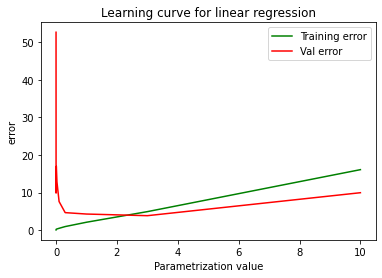

In [279]:
plt.figure()
plt.plot(lambda_vec,error_train,color ="green", label = "Training error")
plt.plot(lambda_vec,error_val, color = "red", label = "Val error")
plt.ylabel("error")
plt.xlabel("Parametrization value")
plt.title("Learning curve for linear regression")
plt.legend()
plt.show()

Finally we use function argmin to get the lambda with the lowest error value

In [291]:
smallest_error_val = min(error_val)
lam = lambda_vec[np.argmin(error_val)]
print('Smallest error of validation data:',smallest_error_val)
print('Lambda value that predicts smallest error:',lam)

Smallest error of validation data: 3.8228986702376937
Lambda value that predicts smallest error: 3


We can now plot to see how are training set fits the validation data with the optimal lambda = 3

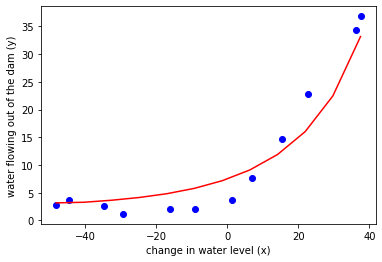

In [281]:
theta_opt = trainLinearReg(X_poly_train_final, y, lam)
X_dummy = np.linspace(min(X),max(X),len(X))
X_dummy_poly = polyFeatures(X_dummy, p)
X_dummy_norm = (X_dummy_poly-mean)/std
X_dummy_train = np.column_stack((np.ones(len(X_dummy_norm)),X_dummy_norm))
h = np.dot(X_dummy_train,theta_opt)
plt.figure()
plt.scatter(x=X, y=y, color="blue")
plt.plot(X_dummy,h, color="red")
plt.ylabel("water flowing out of the dam (y)")
plt.xlabel("change in water level (x)")
plt.show()

In [292]:
h = np.dot(X_poly_test_final, theta_opt)
error_test = np.dot(h-ytest, h-ytest) / (2 * X_poly_test_final.shape[0])
print('Error of test data with optimal lambda:',error_test)

Error of test data with optimal lambda: 3.859887833842918
